In [1053]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from functools import reduce

In [1054]:
gene_info = pd.read_table('geneinfo_beta.txt')
# sig_info = pd.read_table('siginfo_beta.txt', low_memory=False)

In [1055]:
fil = gene_info['feature_space']=='landmark'
genes_lm = gene_info[fil]
genes_lm = genes_lm.set_index('gene_id', drop = True)['gene_symbol']
genes_lm.index = genes_lm.index.astype(str)

In [1056]:
def map_gene_id_to_gene_symbol(genes_lm,signatures_lm):
    genes = genes_lm.copy()
    signatures = signatures_lm.copy()
    # map gene names of CRISPR signatures
    genes.index = genes.index.astype('int')
    signatures.index = signatures.index.map(genes.to_dict())
    return signatures

In [1236]:
signatures_lm = pd.read_csv('signatures_lm_xpr.csv', index_col = 0)
signatures_lm = map_gene_id_to_gene_symbol(genes_lm, signatures_lm)

In [1071]:
# signatures_lm = pd.read_csv('signatures_lm_oe.csv', index_col = 0)
# signatures_lm = map_gene_id_to_gene_symbol(genes_lm, signatures_lm)

In [1079]:
# signatures_lm = pd.read_csv('signatures_lm_sh.csv', index_col = 0)
# signatures_lm = map_gene_id_to_gene_symbol(genes_lm, signatures_lm)

# select genes - kinases, phosphatases

In [1237]:
metadata = pd.read_csv('sasaki_data.csv', index_col = 0)
metadata = metadata.set_index('GeneSymbol', drop=True)

In [1238]:
kinases = list(metadata[metadata['Function'] == 'kinase'].index)
phosphatases = list(metadata[metadata['Function'] == 'phosphatase'].index)

In [1239]:
selected_genes = []
for gene in kinases+phosphatases:
    if gene in signatures_lm.columns:
        selected_genes.append(gene)

# Remove PC1 from gene expression signatures

In [1240]:
def fit_model_pca(signatures):
    pca = PCA(4)
    principalComponents = pca.fit_transform(signatures)
    pcdf=pd.DataFrame(principalComponents,index=signatures.index,columns=['PC1','PC2','PC3', 'PC4'])
    print('Explained variance ratio: ', pca.explained_variance_ratio_)
    return pcdf

In [1241]:
def remove_pc1(signatures, pcdf):
    columns = signatures.columns
    index = signatures.index
    signatures_removed_pc1 = {}
    i = 0
    for cols in columns:
        if i%100 == 0: print(i, end =',')
        X=pcdf['PC1']
        X=sm.add_constant(X)
        model = sm.OLS(signatures[cols],X)
        results=model.fit()
        signatures_removed_pc1[cols] = results.resid
        i = i+1
    signatures_removed_pc1 = pd.DataFrame.from_dict(signatures_removed_pc1)
    print('done')
    return signatures_removed_pc1

In [1242]:
pcdf = fit_model_pca(signatures_lm.T)
signatures_removed_pc1 = remove_pc1(signatures_lm.T, pcdf)
signatures_removed_pc1.T.to_csv('signatures_lm_xpr_pc1_removed.csv')

Explained variance ratio:  [0.29777443 0.09056498 0.05097991 0.04166016]
0,100,200,300,400,500,600,700,800,900,done


In [1195]:
def plot_scatter_with_genes(pcdf, pcs = ('PC1', 'PC2'), genes = [], figsize = (10,10), above_thd = False, thds = (0,0)):
    
    hue_genes = pd.Series(0, index = pcdf.index)
    hue_genes.loc[genes] = 1
    
    fig, ax = plt.subplots(1, figsize = figsize)
    sns.scatterplot(pcdf[pcs[0]], pcdf[pcs[1]], color = 'lightgrey')
    sns.scatterplot(pcdf.loc[genes, pcs[0]], pcdf.loc[genes, pcs[1]], color = 'orange')
    for gene in genes:
        plt.text(x = pcdf.loc[gene, pcs[0]], y = pcdf.loc[gene, pcs[1]], s= gene, fontsize = 10, color = 'black')
    if above_thd:
        genes = pcdf[(pcdf[pcs[0]] > thds[0]) & (pcdf[pcs[1]] > thds[1])].index
        for gene in genes:
            plt.text(x = pcdf.loc[gene, pcs[0]], y = pcdf.loc[gene, pcs[1]], s= gene, fontsize = 8, color = 'black')
    

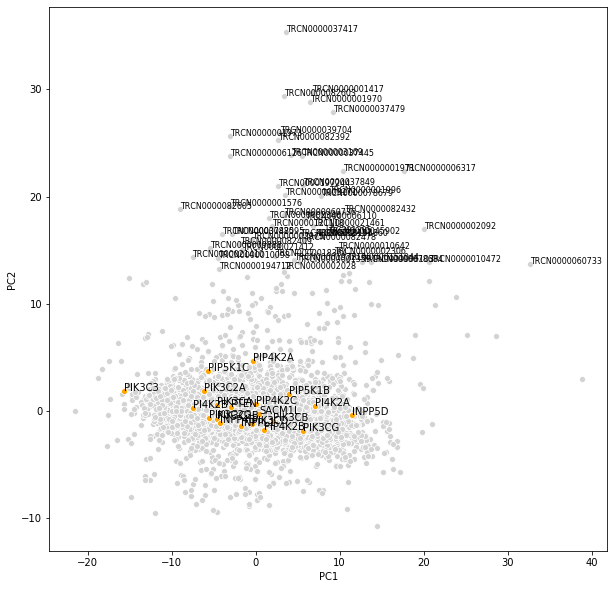

In [1088]:
plot_scatter_with_genes(pcdf, genes = selected_genes, pcs = ('PC1', 'PC2'), above_thd=True, thds = (-10, 13))

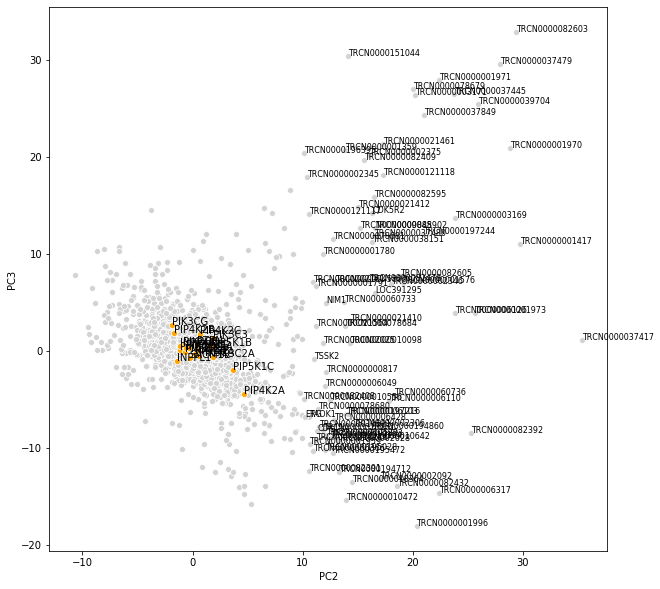

In [1089]:
plot_scatter_with_genes(pcdf, genes = selected_genes, pcs = ('PC2', 'PC3'), above_thd=True, thds = (10, -20))

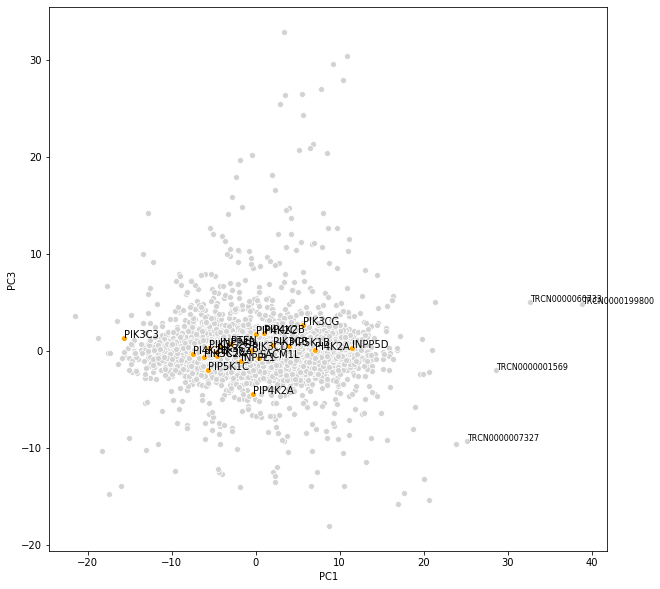

In [1090]:
plot_scatter_with_genes(pcdf, genes = selected_genes, pcs = ('PC1', 'PC3'), above_thd=True, thds = (25, -20))

# Calculate similarities

In [1286]:
signatures_removed_pc1 = pd.read_csv('signatures_lm_sh_pc1_removed.csv', index_col =0)

In [1287]:
selected_genes = []
for gene in kinases+phosphatases:
    if gene in signatures_removed_pc1.columns:
        selected_genes.append(gene)

In [1288]:
kinases_selected = list(np.intersect1d(kinases, selected_genes))
phosphatases_selected = list(np.intersect1d(phosphatases, selected_genes))

In [1289]:
similarities_kinases = pd.DataFrame(index = kinases_selected, columns = kinases_selected)
for gene in kinases_selected:
    for ko in kinases_selected:
        similarities_kinases.loc[gene, ko] = spearmanr(signatures_removed_pc1[gene], signatures_removed_pc1[ko])[0]
similarities_kinases = similarities_kinases.astype('float')

In [1290]:
similarities_phosphatases = pd.DataFrame(index = phosphatases_selected, columns = phosphatases_selected)
for gene in phosphatases_selected:
    for ko in phosphatases_selected:
        similarities_phosphatases.loc[gene, ko] = spearmanr(signatures_removed_pc1[gene], signatures_removed_pc1[ko])[0]
similarities_phosphatases = similarities_phosphatases.astype('float')

In [1291]:
class_colors = dict(zip(metadata['Class'].unique(),
                      list(reversed(sns.color_palette("Spectral", len(metadata['Class'].unique()))))))

In [1292]:
def plot_clustermap(simialrities, title, figsize = (8,8)):
    
    col_colors = pd.DataFrame(metadata[metadata.index.isin(simialrities.columns)]['Class'].map(class_colors))
    g = sns.clustermap(simialrities)
    plt.close()
    masks = ~np.triu(np.ones_like(simialrities, dtype=bool))
    masks = masks[np.argsort(g.dendrogram_row.reordered_ind),:]
    masks = masks[:,np.argsort(g.dendrogram_col.reordered_ind)]
    g = sns.clustermap(simialrities,  cmap = cmap,  center=0, mask = masks, figsize=figsize, 
                      col_colors=col_colors
                      )
    plt.title(title, fontsize = 14)

    ax = g.ax_heatmap
    ax.xaxis.tick_top()
    ax.tick_params(axis='x', labelrotation=45)
    g.ax_row_dendrogram.remove()

In [1293]:
# plot_clustermap(similarities_kinases, 'Kinase sh', figsize = (10, 10))

In [1294]:
# plot_clustermap(similarities_phosphatases, 'Phosphatase sh')

In [1295]:
genes = phosphatases_selected+kinases_selected
similarities_all = pd.DataFrame(index = genes, columns = genes)
for gene in genes:
    for pert in genes:
        similarities_all.loc[gene, pert] = spearmanr(signatures_removed_pc1[gene], signatures_removed_pc1[pert])[0]
similarities_all = similarities_all.astype('float')


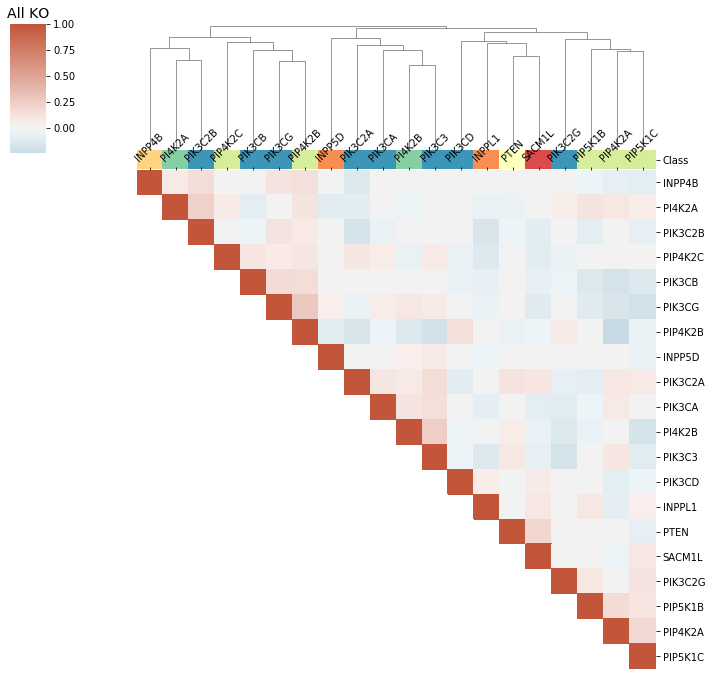

In [1296]:
plot_clustermap(similarities_all, 'All KO', figsize = (10, 10))

In [1297]:
from sklearn.cluster import AgglomerativeClustering


In [1304]:
model = AgglomerativeClustering(linkage='average', n_clusters=4)
clusters = pd.Series(model.fit_predict(similarities_all),index=similarities_all.index)

In [1318]:
# cluster 
metadata.loc[clusters[clusters == 3].index]

,Function,Class,Subclass,Reaction
INPPL1,phosphatase,Phosphoinositide 5-phosphatases,III INPP5,j
PTEN,phosphatase,Phosphoinositide 3-phosphatases,PTEN,"('l', 'a')"
SACM1L,phosphatase,Other phosphatases,Sac,"('a', 'b', 'f')"
PIK3CD,kinase,Phosphoinositide 3-kinases,IA,"('L', 'A', 'E')"


# Quality control

In [1136]:
def plot_correlation_between_common_genes(signatures1, signatures2, plus_selected_genes = []):
    if len(plus_selected_genes) == 0: plus_selected_genes = signatures1.columns
    common_genes = reduce(np.intersect1d, [signatures1.columns, signatures2.columns, plus_selected_genes])
    correlations = pd.Series(index = common_genes, dtype = 'float')
    for gene in common_genes:
        correlations[gene] = spearmanr(signatures1[gene], signatures2[gene])[0]
    if correlations.shape[0] > 2: plt.hist(correlations)
    return correlations

In [1176]:
signatures_removed_pc1_sh = pd.read_csv('signatures_lm_sh_pc1_removed.csv', index_col =0)
signatures_removed_pc1_oe = pd.read_csv('signatures_lm_oe_pc1_removed.csv', index_col =0)
signatures_removed_pc1_xpr = pd.read_csv('signatures_lm_xpr_pc1_removed.csv', index_col =0)

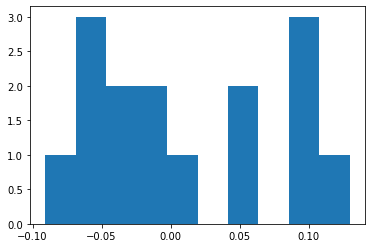

In [1177]:
corr = plot_correlation_between_common_genes(signatures_removed_pc1_xpr,signatures_removed_pc1_sh, phosphatases+kinases)

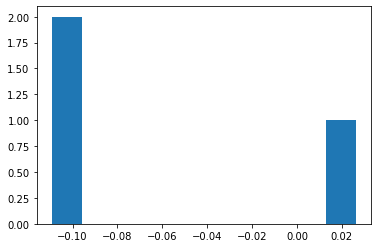

In [1178]:
corr = plot_correlation_between_common_genes(signatures_removed_pc1_xpr,signatures_removed_pc1_oe, phosphatases+kinases)

In [1179]:
corr

PIK3CA   -0.107520
PIK3CD    0.026363
PTEN     -0.109269
dtype: float64

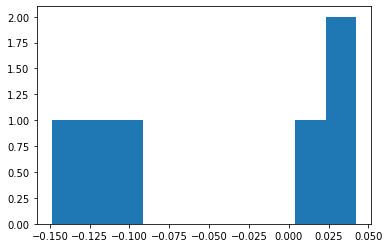

In [1180]:
corr = plot_correlation_between_common_genes(signatures_removed_pc1_sh,signatures_removed_pc1_oe, phosphatases+kinases)

# Qulaity control - Investigate if KO/KD genes have 0, negative expression

In [1208]:
signatures_removed_pc1_sh = pd.read_csv('signatures_lm_sh_pc1_removed.csv', index_col =0)
signatures_removed_pc1_oe = pd.read_csv('signatures_lm_oe_pc1_removed.csv', index_col =0)
signatures_removed_pc1_xpr = pd.read_csv('signatures_lm_xpr_pc1_removed.csv', index_col =0)

In [1147]:
signatures_lm = pd.read_csv('signatures_lm_xpr.csv', index_col = 0)
signatures_lm_xpr = map_gene_id_to_gene_symbol(genes_lm, signatures_lm)
signatures_lm = pd.read_csv('signatures_lm_oe.csv', index_col = 0)
signatures_lm_oe = map_gene_id_to_gene_symbol(genes_lm, signatures_lm)
signatures_lm = pd.read_csv('signatures_lm_sh.csv', index_col = 0)
signatures_lm_sh = map_gene_id_to_gene_symbol(genes_lm, signatures_lm)

In [1148]:
def plot_histogram_expression(signatures, title, genes_selected = []):
    genes = np.intersect1d(signatures.index, signatures.columns)
    genes_expression = signatures.loc[genes, genes]
    genes_expression = pd.Series(np.diag(genes_expression), index=genes_expression.index)
    plt.hist(genes_expression, bins = 20)
    plt.title(title)
    if len(genes_selected) > 0:
        genes_selected = np.intersect1d(genes_selected, genes_expression.index)
        print(genes_expression.loc[genes_selected])

gene_id
PIK3C3    -2.575215
PIK3CA    -0.136681
PIP4K2B   -1.834037
dtype: float64


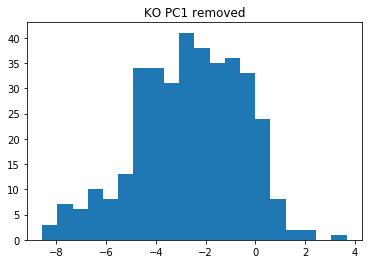

In [1209]:
plot_histogram_expression(signatures_removed_pc1_xpr, 'KO PC1 removed', genes_selected = kinases+phosphatases)

INPP4B    -1.931779
PIK3C2B   -1.859683
PIK3C3    -1.193132
PIK3CA    -0.368149
PIP4K2B   -2.125352
SACM1L    -4.305020
dtype: float64


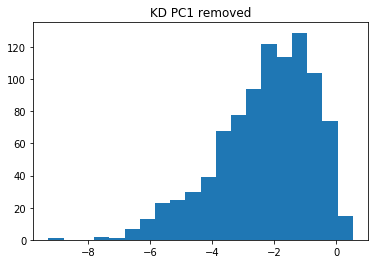

In [1156]:
plot_histogram_expression(signatures_removed_pc1_sh, 'KD PC1 removed', genes_selected = kinases+phosphatases)

PIK3CA   -0.169309
SACM1L   -0.351799
dtype: float64


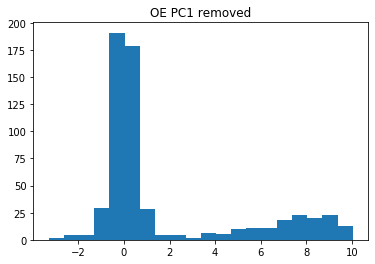

In [1182]:
plot_histogram_expression(signatures_removed_pc1_oe, 'OE PC1 removed', genes_selected = kinases+phosphatases)

In [1163]:
signatures_removed_pc1_oe.index[120:130]

Index(['DPH2', 'DSG2', 'TSC22D3', 'DUSP3', 'DUSP4', 'DUSP6', 'TOR1A', 'E2F2',
       'ECH1', 'EDN1'],
      dtype='object')

# PCA with removed PC1

In [1183]:
pcdf = fit_model_pca(signatures_removed_pc1_oe.T)

Explained variance ratio:  [0.12382688 0.04520214 0.02951077 0.02511835]


In [1184]:
selected_genes = []
for gene in kinases+phosphatases:
    if gene in signatures_removed_pc1_oe.columns:
        selected_genes.append(gene)

In [1185]:
selected_genes

['PIK3CA', 'PIK3CB', 'PIK3CD', 'PIK3CG', 'PIP5K3', 'PTEN', 'MTM1', 'SACM1L']

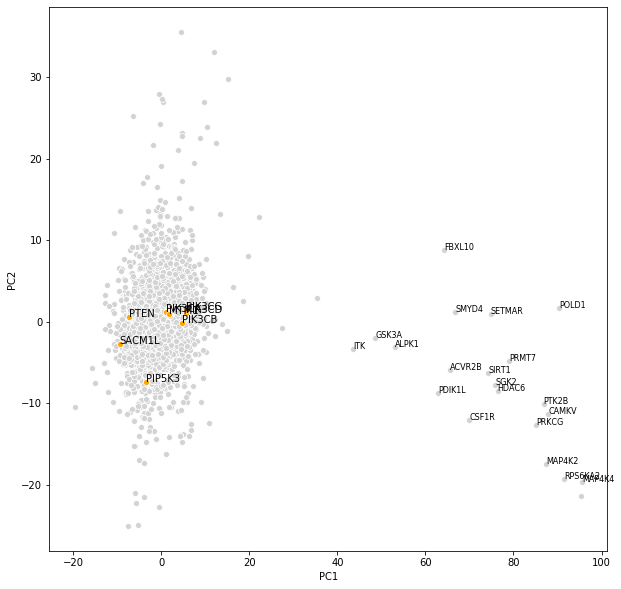

In [1187]:
plot_scatter_with_genes(pcdf, genes = selected_genes, pcs = ('PC1', 'PC2'), above_thd=True, thds = (40, -20))